# Kunlin_CSC594-910Online_FinalProject

## PART 1: Import Libraries and Data

In [404]:
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import gensim
from gensim.models import Word2Vec
from bs4 import BeautifulSoup
import os
import re
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np

In [605]:
def chunk_wikitext(text_oh):
    #text = nltk.clean_html(text)
    text_oh = BeautifulSoup(text_oh, 'html.parser')
    text = text_oh.get_text()
    text = re.sub(r'\[\[.*?:.*?\]\]', '', text)    # remove interwiki links
    template_depth = 0
    in_link = in_ext_link = False
    link_words = []
    pieces = []
    for word in nltk.wordpunct_tokenize(text):
        # skip everything in template braces
        if '{{' in word:
            template_depth += 1
        elif '}}' in word:
            template_depth -= 1
        elif template_depth == 0:
            # detect links
            if '[[' in word:
                in_link = True
            elif ']]' in word:
                # at the end of a link, output it as a named entity chunk
                if link_words:
                    pieces.append(nltk.Tree('NE', link_words))
                    link_words = []
                    in_link = False
            elif '[' in word:
                # start over if the link has | marking an alternate name
                in_ext_link = True
            elif in_ext_link and ']' in word:
                in_ext_link = False
            elif '|' in word and in_link:
                link_words = []
            else:
                if in_link:
                    link_words.append(word)
                elif not in_ext_link:
                    pieces.append(word)
    return nltk.Tree('S', pieces)


# FINAL USED TO READ IN THE TEXT DATA
def readin_text_nohtml_notree(path, limit_n = 50000):
    '''input: path for original text from the datset file
    output: word tokenized sentences from all the files in one list
    needed library: os, re, BeautifulSoup'''
    files = list()
    n = 0
    for filename in os.listdir(path):
        n += 1
        if n < limit_n:
            with open(os.path.join(path,filename), 'rU') as file:
                text = file.read()
                text_tree = chunk_wikitext(text)
                text_notree = ' '.join(word for word in text_tree.leaves())
                sentences = nltk.sent_tokenize(text_notree) 
                sentences = [nltk.word_tokenize(sent) for sent in sentences] 
                files += sentences
        else: break
    return files

In [606]:
%%time
path = 'articles/'
test1_notree = readin_text_nohtml_notree(path)

/Users/Queena/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:62: DeprecationWarning: 'U' mode is deprecated


CPU times: user 14min 57s, sys: 3min 13s, total: 18min 10s
Wall time: 20min 44s


In [57]:
%%time
path = 'articles/'
test2_notree = readin_text_nohtml_notree(path, limit_n = 10000)

/Users/Queena/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:62: DeprecationWarning: 'U' mode is deprecated


CPU times: user 2min 52s, sys: 15.7 s, total: 3min 7s
Wall time: 3min 20s


In [919]:
len(test1_notree)

2468199

In [921]:
print(test1_notree[0])

['The', "'", "''", 'Battle', 'of', 'Goliad', "'", "''", 'was', 'the', 'second', 'skirmish', 'of', 'the', 'Texas', 'Revolution', 'In', 'the', 'early', '-', 'morning', 'hours', 'of', 'October', '10', ',', '1835', ',', 'rebellious', 'Texas', 'settlers', 'attacked', 'the', 'Mexican', 'Army', 'soldiers', 'garrisoned', 'at', 'Presidio', 'La', 'Bahía', 'a', 'fort', 'near', 'the', 'Mexican', 'Texas', 'settlement', 'of', 'Goliad', 'La', 'Bahía', 'lay', 'halfway', 'between', 'the', 'only', 'other', 'large', 'garrison', 'of', 'Mexican', 'soldiers', '(', 'at', 'San', 'Antonio', 'de', 'Béxar', 'and', 'the', 'major', 'Texas', 'port', 'of', 'Copano', 'In', 'September', ',', 'Texian', 's', 'began', 'plotting', 'to', 'kidnap', 'Mexican', 'General', 'Martín', 'Perfecto', 'de', 'Cos', 'who', 'was', 'en', 'route', 'to', 'Goliad', 'to', 'attempt', 'to', 'quell', 'the', 'unrest', 'in', 'Texas', '.']


## PART 2: INITIAL EXPLORATION

### Step 1: Inspiration
Based on the WordNet word search, there are few words coming to be very related from my perspective -- locate, headquarter, site (someplace is sited somewhere | someone site something somewhere), 

In [607]:
%%time
test1_word2vec = Word2Vec(test1_notree)

CPU times: user 16min 53s, sys: 38 s, total: 17min 31s
Wall time: 7min 54s


In [41]:
print (test1_word2vec.most_similar('location', topn=50))

[('site', 0.6058415770530701), ('constituency_westminster', 0.5633498430252075), ('post_town', 0.5548974871635437), ('name1', 0.5502062439918518), ('shire_county', 0.5345453023910522), ('lc', 0.5328227877616882), ('EPac', 0.5286909937858582), ('destination', 0.5191577076911926), ('jct', 0.518252968788147), ('Atl', 0.5171365141868591), ('image2', 0.5147724151611328), ('postcode_district', 0.5114125609397888), ('rev3', 0.5049183368682861), ('rev3Score', 0.49651363492012024), ('LowestElevUS', 0.49410396814346313), ('shire_district', 0.49164915084838867), ('ISOCode', 0.4906151294708252), ('Panorama', 0.48955169320106506), ('linktext', 0.48678964376449585), ('civil_parish', 0.48390722274780273), ('rev4', 0.4818711578845978), ('terminus', 0.4813475012779236), ('LowestElev', 0.47682446241378784), ('Square', 0.4745105803012848), ('compid', 0.4744529724121094), ('caption1', 0.47406503558158875), ('harbour', 0.4734512269496918), ('suburb', 0.47287991642951965), ('LowestPoint', 0.4719074964523315

In [42]:
print (test1_word2vec.most_similar('locations', topn=50))

[('sites', 0.8120473027229309), ('places', 0.7877007722854614), ('destinations', 0.7245355844497681), ('venues', 0.7244571447372437), ('localities', 0.7218211889266968), ('landmarks', 0.6973790526390076), ('attractions', 0.692953884601593), ('harbours', 0.6888949275016785), ('wrecks', 0.685008704662323), ('areas', 0.6831030249595642), ('terminals', 0.6795560717582703), ('airports', 0.6770663261413574), ('environments', 0.6732147932052612), ('establishments', 0.6676057577133179), ('neighborhoods', 0.6646368503570557), ('platforms', 0.6636717915534973), ('habitats', 0.6635812520980835), ('resorts', 0.6626397967338562), ('arrivals', 0.6616767644882202), ('parks', 0.6608238816261292), ('amenities', 0.6588262319564819), ('pubs', 0.6586792469024658), ('lodges', 0.6577292084693909), ('museums', 0.6574202179908752), ('stations', 0.6573600172996521), ('occurrences', 0.6555509567260742), ('streams', 0.6509867310523987), ('lakes', 0.6500701308250427), ('trails', 0.6497417688369751), ('ports', 0.6

In [43]:
print (test1_word2vec.most_similar('located', topn=50))

[('situated', 0.9064340591430664), ('Located', 0.7691787481307983), ('sited', 0.7560874819755554), ('housed', 0.7221107482910156), ('headquartered', 0.7084997296333313), ('plaza', 0.6187422275543213), ('Situated', 0.6162080764770508), ('resides', 0.6112284064292908), ('neighbourhood', 0.6066041588783264), ('positioned', 0.6050049066543579), ('neighborhood', 0.6044189929962158), ('interred', 0.603449285030365), ('centred', 0.6001233458518982), ('lies', 0.5969289541244507), ('sits', 0.5967823266983032), ('erected', 0.5959773659706116), ('outskirts', 0.5929664969444275), ('skyline', 0.5916697978973389), ('buried', 0.5885488390922546), ('tallest', 0.585128128528595), ('Otago', 0.5851196050643921), ('bordered', 0.584554135799408), ('seafront', 0.5831277966499329), ('nestled', 0.581925094127655), ('comune', 0.5755903720855713), ('suburb', 0.5696147680282593), ('constructed', 0.569222092628479), ('Campus', 0.5681867003440857), ('centered', 0.5668160319328308), ('disused', 0.5657599568367004),

In [44]:
print (test1_word2vec.most_similar('locate', topn=50))

[('collect', 0.8234214782714844), ('navigate', 0.8174417018890381), ('deliver', 0.8120916485786438), ('retrieve', 0.7942471504211426), ('detect', 0.7832988500595093), ('manage', 0.782348096370697), ('gather', 0.7770453095436096), ('disperse', 0.7715142965316772), ('manipulate', 0.7678436040878296), ('enable', 0.7651959657669067), ('install', 0.7651886343955994), ('stabilize', 0.7636471390724182), ('find', 0.7620754837989807), ('transmit', 0.7614277005195618), ('expose', 0.7602881193161011), ('conserve', 0.7598457932472229), ('obtain', 0.7561533451080322), ('send', 0.7550832033157349), ('acquire', 0.7546961903572083), ('assemble', 0.7533800601959229), ('distribute', 0.7472652792930603), ('isolate', 0.746103823184967), ('divert', 0.743084192276001), ('respond', 0.7430269122123718), ('replicate', 0.7414101362228394), ('inspect', 0.7409871220588684), ('monitor', 0.7396875023841858), ('bury', 0.7367282509803772), ('initiate', 0.7361067533493042), ('deploy', 0.7360992431640625), ('steal', 0.

In [47]:
print (test1_word2vec.most_similar('locates', topn=50))

[('petrologic', 0.5890767574310303), ('fosters', 0.567924976348877), ('etiological', 0.5678845643997192), ('constrains', 0.5595799088478088), ('restrains', 0.5525587797164917), ('corrects', 0.5497102737426758), ('broadens', 0.5440458655357361), ('adapts', 0.5436800122261047), ('calculates', 0.5425565838813782), ('engenders', 0.5396884679794312), ('encapsulates', 0.5375760793685913), ('confounds', 0.5331070423126221), ('solves', 0.5322425961494446), ('psychophysical', 0.5314218997955322), ('deactivates', 0.5280733704566956), ('straddles', 0.5249674320220947), ('detects', 0.5246526002883911), ('bidirectional', 0.5241344571113586), ('manipulates', 0.5237739682197571), ('refines', 0.522264301776886), ('necessitates', 0.5176503658294678), ('modelview', 0.5173503160476685), ('enhances', 0.5172029137611389), ('suffices', 0.5171870589256287), ('lessens', 0.5171679258346558), ('omits', 0.5167201161384583), ('justifies', 0.5147794485092163), ('delineating', 0.5146296620368958), ('affords', 0.514

In [48]:
print (test1_word2vec.most_similar('Location', topn=50))

[('Landmarks', 0.7084018588066101), ('Geography', 0.6581853628158569), ('Trowulan', 0.6571639776229858), ('Subdivisions', 0.6568329334259033), ('Largest', 0.6485852599143982), ('Tributaries', 0.6485441327095032), ('Attractions', 0.6461562514305115), ('Hiking', 0.6448706984519958), ('Candi', 0.634350597858429), ('Nearby', 0.6333515644073486), ('Climate', 0.6327184438705444), ('Panorama', 0.6235895156860352), ('Situated', 0.6221861243247986), ('Coordinates', 0.6219463348388672), ('Fuji', 0.619540810585022), ('Towns', 0.6186179518699646), ('Locations', 0.6171537637710571), ('Cuisine', 0.6161313652992249), ('Position', 0.6160439252853394), ('Dyfi', 0.6118125319480896), ('Amenities', 0.6104545593261719), ('Villages', 0.6096140146255493), ('Geographically', 0.6081145405769348), ('Palus', 0.6071576476097107), ('Llaima', 0.6067270040512085), ('Pevensey', 0.6049631237983704), ('Triglav', 0.6035611629486084), ('Neman', 0.6028668880462646), ('Kuantan', 0.6022984385490417), ('Vallis', 0.6014095544

In [49]:
print (test1_word2vec.most_similar('Located', topn=50))

[('Situated', 0.8878246545791626), ('located', 0.7691787481307983), ('situated', 0.7460998892784119), ('seafront', 0.7129974365234375), ('foothills', 0.7090229988098145), ('Peak', 0.7029186487197876), ('Plaza', 0.6915350556373596), ('Arriving', 0.6886391043663025), ('Downtown', 0.686585545539856), ('Lying', 0.6857490539550781), ('Escarpment', 0.6853693723678589), ('outskirts', 0.6849063038825989), ('Midtown', 0.6824685335159302), ('Terrace', 0.6819868087768555), ('Campus', 0.6803112030029297), ('Gorge', 0.679448664188385), ('southwest', 0.6767296195030212), ('Blvd', 0.6721588373184204), ('Verdes', 0.6672504544258118), ('Turnpike', 0.6649823784828186), ('headwaters', 0.6649406552314758), ('Pennines', 0.6639231443405151), ('Scheldt', 0.6635293960571289), ('Neckar', 0.66324782371521), ('Otago', 0.6620655059814453), ('Dunedin', 0.6614440679550171), ('Boulevard', 0.6594688296318054), ('Kanyakumari', 0.6590480804443359), ('Palos', 0.6573858261108398), ('Mount', 0.6556409001350403), ('Mall', 

In [50]:
print (test1_word2vec.most_similar('headquarter', topn=50))

[('Prisons', 0.6476958990097046), ('newest', 0.61555016040802), ('ARC', 0.6094487309455872), ('NGO', 0.6089147329330444), ('clearinghouse', 0.6022433042526245), ('LPI', 0.5981800556182861), ('headquarters', 0.5976259112358093), ('Supercomputing', 0.5928834676742554), ('licensee', 0.580588698387146), ('ITC', 0.5793561935424805), ('MFAH', 0.5747969746589661), ('Qantas', 0.5741773247718811), ('Centres', 0.573453426361084), ('Curricula', 0.572895884513855), ('Firearm', 0.5727336406707764), ('Inspectorate', 0.5696656703948975), ('Debenhams', 0.5693502426147461), ('Sector', 0.5691770315170288), ('YMCA', 0.5676238536834717), ('Aveo', 0.566767156124115), ('NFSA', 0.5649860501289368), ('Cargo', 0.5649164915084839), ('Kinko', 0.5647701025009155), ('Retail', 0.5647460222244263), ('Seafarers', 0.5645826458930969), ('DigiPen', 0.5642707347869873), ('subsidiaries', 0.5638725757598877), ('IET', 0.5635808706283569), ('Delegation', 0.5626702308654785), ('Networks', 0.5613071918487549), ('Ventures', 0.5

In [51]:
print (test1_word2vec.most_similar('headquarters', topn=50))

[('offices', 0.6745361685752869), ('headquartered', 0.6471269130706787), ('Headquarters', 0.6406798958778381), ('Base', 0.6203516125679016), ('flagship', 0.6199315786361694), ('airport', 0.60589599609375), ('capital', 0.6052305698394775), ('hub', 0.6015400290489197), ('headquarter', 0.5976259708404541), ('Manila', 0.5972790122032166), ('base', 0.5938427448272705), ('residence', 0.5935289263725281), ('depot', 0.5851858854293823), ('barracks', 0.5807538032531738), ('subsidiaries', 0.5772446990013123), ('centre', 0.5765416622161865), ('department', 0.5763296484947205), ('capitol', 0.5700022578239441), ('airports', 0.5681322813034058), ('Depot', 0.5645895600318909), ('home', 0.5635899901390076), ('suburbs', 0.5579538941383362), ('museum', 0.5570180416107178), ('Barracks', 0.5569081902503967), ('seat', 0.5553616881370544), ('station', 0.5528665781021118), ('HQ', 0.550951361656189), ('remit', 0.5505502223968506), ('airfield', 0.5504106879234314), ('Hotel', 0.5499926805496216), ('shipyard', 0

In [52]:
print (test1_word2vec.most_similar('headquartered', topn=50))

[('located', 0.7084997892379761), ('headquarters', 0.6471269130706787), ('housed', 0.6246206164360046), ('chartered', 0.6200763583183289), ('inaugurated', 0.610547661781311), ('situated', 0.6044696569442749), ('stationed', 0.6038364171981812), ('MSA', 0.6009718179702759), ('Base', 0.5938100814819336), ('interred', 0.5861932039260864), ('Metro', 0.5779229998588562), ('Irkutsk', 0.5771461129188538), ('Pensacola', 0.5727260112762451), ('nationalised', 0.5725271105766296), ('Minsk', 0.5722251534461975), ('Harrisburg', 0.5691729187965393), ('sited', 0.5666592121124268), ('Manila', 0.5602496862411499), ('Peoria', 0.5584858059883118), ('redeveloped', 0.55790776014328), ('Johannesburg', 0.5559183359146118), ('Barracks', 0.5558871626853943), ('Saskatchewan', 0.554646909236908), ('Stockton', 0.5515681505203247), ('restructured', 0.5511096119880676), ('Savannah', 0.5491160154342651), ('Manitoba', 0.548360288143158), ('Zambia', 0.5480493307113647), ('Kinston', 0.547827422618866), ('privatised', 0.

In [53]:
print (test1_word2vec.most_similar('Headquartered', topn=50))

[('Discogs', 0.823458194732666), ('Fairgrounds', 0.7964089512825012), ('þansi', 0.7902523875236511), ('Spennymoor', 0.7830210328102112), ('ucc', 0.7775673866271973), ('Bawdrip', 0.774205207824707), ('HKTDC', 0.7718158960342407), ('Phare', 0.7702826857566833), ('Ngandu', 0.7686895132064819), ('Suzuka', 0.7682216763496399), ('Hagenau', 0.76801598072052), ('Shantiniketan', 0.765975296497345), ('Golubovci', 0.7644968628883362), ('Montereau', 0.7625289559364319), ('Giv', 0.7622693777084351), ('Lakeside', 0.7618764638900757), ('Holloman', 0.7604546546936035), ('Horbury', 0.759763240814209), ('Enns', 0.759399950504303), ('Lakewood', 0.7558616995811462), ('Shoreline', 0.7554383277893066), ('Kenmore', 0.7540799379348755), ('Gillman', 0.7535753846168518), ('Webpage', 0.7528054118156433), ('Bacteriology', 0.7522106766700745), ('Schleissheim', 0.7505224347114563), ('swayamvara', 0.748660683631897), ('Bita', 0.7464599609375), ('Ayacucho', 0.7456669807434082), ('Machynlleth', 0.7454524040222168), ('

In [54]:
print (test1_word2vec.most_similar('Headquarters', topn=50))

[('HQ', 0.8126102089881897), ('Operations', 0.7990264892578125), ('Command', 0.7930790185928345), ('Depot', 0.7917972207069397), ('Base', 0.7644708752632141), ('RAAF', 0.7635332345962524), ('Troops', 0.7524137496948242), ('Detachment', 0.7312366366386414), ('GHQ', 0.7300654649734497), ('Aviation', 0.7296973466873169), ('Liaison', 0.7287096381187439), ('Ordnance', 0.7250630855560303), ('Combined', 0.7223758101463318), ('Directorate', 0.7190324664115906), ('Forces', 0.7185176610946655), ('Training', 0.7180801033973694), ('Commandant', 0.7154337167739868), ('Air', 0.7119998335838318), ('Task', 0.7116948962211609), ('Volunteer', 0.7091430425643921), ('Naval', 0.7076602578163147), ('Cadet', 0.7072911858558655), ('Marine', 0.7066165208816528), ('Force', 0.70594722032547), ('RAF', 0.6998233795166016), ('Unit', 0.6965962648391724), ('Support', 0.6962891221046448), ('Intelligence', 0.6955546140670776), ('Constabulary', 0.6947430968284607), ('Commando', 0.6944484710693359), ('Staff', 0.694413006

### Step 2: Pattern Definition
Based on the interesting results from WordNet and Word2Vec above, I will try to build the pattern based on the findings. 

In [187]:
def get_inspiration(dataset, word, limit_n=100):
    n = 0 
    for sent in dataset:
        if n<limit_n:
            if word in sent:
                n += 1
                print(sent)
        else: break

In [672]:
get_inspiration(test1_notree,'lying')

["'", "''", 'Garoua', "'", "''", 'is', 'an', 'important', 'port', 'city', 'and', 'the', 'capital', 'of', 'the', 'North', 'Province', 'of', 'Cameroon', 'lying', 'on', 'the', 'Benue', 'River', 'It', 'is', 'the', 'centre', 'of', 'trade', 'of', 'the', 'surrounding', 'agricultural', 'region', 'and', 'also', 'houses', 'several', 'textile', 'processing', 'facilities', '.']
["'", "''", 'Bangsar', "'", "''", ',', 'also', "'", "''", 'Bungsar', "'", "''", '(', "''", 'archaic', "''", ')', ',', 'is', 'an', 'affluent', 'residential', 'suburb', 'on', 'the', 'outskirts', 'of', 'Kuala', 'Lumpur', 'lying', 'about', 'south', '-', 'west', 'of', 'the', 'city', 'centre', '.']
['As', 'the', 'fawn', 'approaches', 'two', 'months', 'old', 'it', 'spends', 'less', 'time', 'lying', 'out', 'and', 'more', 'time', 'with', 'its', 'mother', '.']
['Eventually', 'the', 'lying', 'out', 'ends', '.']
['Often', 'he', 'depicted', 'woman', 'and', 'children', 'in', 'leisurely', 'poses', ',', 'relaxing', 'on', 'a', 'park', 'benc

['Though', 'this', 'definition', 'emphasizes', 'the', 'use', 'of', 'lying', 'and', 'falsehoods', ',', 'skilled', 'demagogues', 'often', 'need', 'to', 'use', 'only', "''", 'special', 'emphasis', "''", 'by', 'which', 'an', 'uncritical', 'listener', 'will', 'be', 'led', 'to', 'draw', 'the', 'desired', 'conclusion', 'themselves', '.']
['At', 'least', 'one', 'structure', 'in', 'the', 'Las', 'Monjas', 'Group', 'features', 'an', 'ornate', 'facade', 'and', 'masked', 'doorway', 'that', 'are', 'typical', 'examples', 'of', 'Chenes', '-', 'style', 'architecture', ',', 'a', 'style', 'centred', 'upon', 'a', 'region', 'in', 'the', 'north', 'of', 'Campeche', 'state', ',', 'lying', 'between', 'the', 'Puuc', 'and', 'Río', 'Bec', 'regions', '.']
['The', 'result', 'was', 'a', 'spacious', 'mansion', ',', 'lying', 'parallel', 'to', 'Whitehall', 'Palace', 'with', 'a', 'view', 'of', 'St', '.']
['He', 'imagined', 'the', 'Earth', 'lying', 'at', 'the', 'centre', 'of', 'the', 'universe', '(', 'the', 'geocentric',

['===', 'Communication', '===', 'Dippers', '’', 'calls', 'are', 'loud', 'and', 'high', '-', 'pitched', ',', 'being', 'similar', 'to', 'calls', 'made', 'by', 'other', 'birds', 'on', 'fast', 'rivers', ';', 'the', 'call', 'frequencies', 'lying', 'within', 'a', 'narrow', 'range', 'of', '4', '.']
['Johnson', ',', 'an', 'editorial', 'cartoonist', 'with', 'the', 'Canton', 'Repository', 'was', 'only', 'able', 'to', 'picture', 'the', 'Canton', 'team', 'as', 'only', 'a', 'man', 'with', 'a', 'club', 'lying', 'in', 'wait', 'for', 'the', 'Massillon', 'Tiger', '.']
['The', "'", "''", 'Frisii', "'", "''", 'were', 'an', 'ancient', 'Germanic', 'tribe', 'living', 'in', 'the', 'low', '-', 'lying', 'region', 'between', 'the', 'Zuiderzee', 'and', 'the', 'River', 'Ems', 'In', 'the', 'Germanic', 'pre', 'Migration', 'Period', '(', 'i', '.']
['After', 'several', 'hundred', 'years', 'of', 'favorable', 'conditions', ',', 'the', 'environment', 'in', 'all', 'of', 'the', 'low', '-', 'lying', 'coastal', 'regions', '

['com', '/', 'hardware', '/', 'news', '/', '2007', '/', '06', '/', 'study', '-', 'inkjet', '-', 'printers', '-', 'are', '-', 'filthy', '-', 'lying', '-', 'thieves', '.']
['ars', '|', 'title', '=', 'Study', ':', 'Inkjet', 'printers', 'are', 'filthy', ',', 'lying', 'thieves', '|', 'first', '=', 'Ken', '|', 'last', '=', 'Fisher', '|', 'date', '=', '2007', '-', '06', '-', '18', '|', 'publisher', 'Ars', 'Technica', 'accessdate', '=', '2009', '-', '08', '-', '13', 'This', 'problem', 'is', 'further', 'compounded', 'with', 'the', 'use', 'of', 'one', '-', 'piece', 'multi', '-', 'ink', 'cartridges', ',', 'which', 'are', 'declared', 'empty', 'as', 'soon', 'as', 'one', 'color', 'runs', 'low', '.']
['He', 'lies', 'not', 'only', 'supine', ',', 'but', 'paralyzed', ',', 'and', 'deserves', 'to', 'suffer', 'like', 'others', 'who', 'take', 'their', 'lickings', "'", 'lying', 'down', '.', "'", "''"]
['Cape', 'May', 'is', 'generally', 'low', '-', 'lying', ';', 'its', 'highest', 'point', ',', 'at', 'the', 'i

##### Note: first thing in the pattenexploration, find out the sentence around word IN -- try to find the patterns or good seed tuples. 

In [427]:
def grammar_in(dataset): 
    '''dataset: lists of word tokenized sentences'''
    # Sixth part: no verb or noun, only with prep showing the location relationship
    IN_grammar = r"""
    NE: {<NNP|NNPS>+(<,><NNP|NNPS>)?}
    NEP: {(<DT>?<JJ>*<NN>*<IN>)?<NE>}
    NP: {<DT>?<JJ>*<CD>?<NN.*>+<POS>?<NN.*>*<CD>?}
    VB: {<VBZ|VBP>}
    CLAUSE1: {<NP><VB>?<VBN>?<IN><NEP>}
    CLAUSE2: {<NEP><VBN><NP>}
    """
    
    cp = nltk.RegexpParser(IN_grammar)
    return_list = list()
    for sent in dataset:
        tags = pos_tag(sent)
        tree = cp.parse(tags)
        for subtree in tree.subtrees():
            if subtree.label() == 'CLAUSE1' or 'CLAUSE2':
                leave = subtree.leaves()
                return_list.append(leave)
                #return_list.append(sent)
                break
    return return_list

In [413]:
%%time
grammar_in_list = grammar_in(test1_notree)

CPU times: user 19min 21s, sys: 57.6 s, total: 20min 19s
Wall time: 21min 20s


In [415]:
len(grammar_in_list)

496629

In [416]:
grammar_in_list[:100]

[[('The', 'DT'),
  ("'", "''"),
  ("''", "''"),
  ('Battle', 'NNP'),
  ('of', 'IN'),
  ('Goliad', 'NNP'),
  ("'", 'POS'),
  ("''", "''"),
  ('was', 'VBD'),
  ('the', 'DT'),
  ('second', 'JJ'),
  ('skirmish', 'NN'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('Texas', 'NNP'),
  ('Revolution', 'NNP'),
  ('In', 'IN'),
  ('the', 'DT'),
  ('early', 'JJ'),
  ('-', ':'),
  ('morning', 'NN'),
  ('hours', 'NNS'),
  ('of', 'IN'),
  ('October', 'NNP'),
  ('10', 'CD'),
  (',', ','),
  ('1835', 'CD'),
  (',', ','),
  ('rebellious', 'JJ'),
  ('Texas', 'NNP'),
  ('settlers', 'NNS'),
  ('attacked', 'VBD'),
  ('the', 'DT'),
  ('Mexican', 'JJ'),
  ('Army', 'NNP'),
  ('soldiers', 'NNS'),
  ('garrisoned', 'VBD'),
  ('at', 'IN'),
  ('Presidio', 'NNP'),
  ('La', 'NNP'),
  ('Bahía', 'NNP'),
  ('a', 'DT'),
  ('fort', 'NN'),
  ('near', 'IN'),
  ('the', 'DT'),
  ('Mexican', 'NNP'),
  ('Texas', 'NNP'),
  ('settlement', 'NN'),
  ('of', 'IN'),
  ('Goliad', 'NNP'),
  ('La', 'NNP'),
  ('Bahía', 'NNP'),
  ('lay', 'VBD'),
  (

##### Note: Based on the results above, it's very sparse and very few extracted sentences are about location. Part of the reasons is the super diversified IN words vocabulary. In the following steps, there are some semantic twists applied to the code -- limit the IN words in ['in', 'at', 'to', 'on']. This is the finding based on English human knowledge and the findings from the above results. 

In [425]:
def grammar_in(dataset): 
    '''dataset: lists of word tokenized sentences'''
    # Sixth part: no verb or noun, only with prep showing the location relationship
    IN_list_tag = [('in','IN'),('at','IN'),('to','IN'),('on','IN')]
    IN_grammar = r"""
    NE: {<NNP|NNPS>+(<,><NNP|NNPS>)?}
    NEP: {(<DT>?<JJ>*<NN>*<IN>)?<NE>}
    NP: {<DT>?<JJ>*<CD>?<NN.*>+<POS>?<NN.*>*<CD>?}
    VB: {<VBZ|VBP>}
    CLAUSE1: {<NP><VB>?<VBN>?<IN><NEP>}
    CLAUSE2: {<NEP><VBN><NP>}
    """
    
    cp = nltk.RegexpParser(IN_grammar)
    return_list = list()
    for sent in dataset:
        tags = pos_tag(sent)
        tree = cp.parse(tags)
        for subtree in tree.subtrees():
            if subtree.label() == 'CLAUSE1' or 'CLAUSE2':
                leave = subtree.leaves()
                if set(IN_list_tag).intersection(set(leave)):
                    return_list.append(leave)
                #return_list.append(sent)
                    break
    return return_list

In [426]:
%%time
grammar_in_list2 = grammar_in(test2_notree)

CPU times: user 17min 59s, sys: 23 s, total: 18min 22s
Wall time: 18min 43s


In [428]:
len(grammar_in_list2)

187832

In [429]:
grammar_in_list2[:100]

[[('The', 'DT'),
  ("'", "''"),
  ("''", "''"),
  ('Battle', 'NNP'),
  ('of', 'IN'),
  ('Goliad', 'NNP'),
  ("'", 'POS'),
  ("''", "''"),
  ('was', 'VBD'),
  ('the', 'DT'),
  ('second', 'JJ'),
  ('skirmish', 'NN'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('Texas', 'NNP'),
  ('Revolution', 'NNP'),
  ('In', 'IN'),
  ('the', 'DT'),
  ('early', 'JJ'),
  ('-', ':'),
  ('morning', 'NN'),
  ('hours', 'NNS'),
  ('of', 'IN'),
  ('October', 'NNP'),
  ('10', 'CD'),
  (',', ','),
  ('1835', 'CD'),
  (',', ','),
  ('rebellious', 'JJ'),
  ('Texas', 'NNP'),
  ('settlers', 'NNS'),
  ('attacked', 'VBD'),
  ('the', 'DT'),
  ('Mexican', 'JJ'),
  ('Army', 'NNP'),
  ('soldiers', 'NNS'),
  ('garrisoned', 'VBD'),
  ('at', 'IN'),
  ('Presidio', 'NNP'),
  ('La', 'NNP'),
  ('Bahía', 'NNP'),
  ('a', 'DT'),
  ('fort', 'NN'),
  ('near', 'IN'),
  ('the', 'DT'),
  ('Mexican', 'NNP'),
  ('Texas', 'NNP'),
  ('settlement', 'NN'),
  ('of', 'IN'),
  ('Goliad', 'NNP'),
  ('La', 'NNP'),
  ('Bahía', 'NNP'),
  ('lay', 'VBD'),
  (

In [430]:
grammar_in_list2[-100:]

[[('Sam', 'NNP'),
  ('Foster', 'NNP'),
  ('learned', 'VBD'),
  ('about', 'IN'),
  ('the', 'DT'),
  ('technique', 'NN'),
  ('of', 'IN'),
  ('injection', 'NN'),
  ('molding', 'NN'),
  ('and', 'CC'),
  ('brought', 'VBD'),
  ('it', 'PRP'),
  ('to', 'TO'),
  ('the', 'DT'),
  ('United', 'NNP'),
  ('States', 'NNPS'),
  (',', ','),
  ('quickly', 'RB'),
  ('turning', 'VBG'),
  ('Foster', 'NNP'),
  ('Grant', 'NNP'),
  ('into', 'IN'),
  ('one', 'CD'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('leading', 'VBG'),
  ('plastic', 'NN'),
  ('manufacturers', 'NNS'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('country', 'NN'),
  ('.', '.')],
 [('Due', 'JJ'),
  ('to', 'TO'),
  ('the', 'DT'),
  ('growth', 'NN'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('company', 'NN'),
  (',', ','),
  ('Sam', 'NNP'),
  ('Foster', 'NNP'),
  ('hired', 'VBD'),
  ('his', 'PRP$'),
  ('son', 'NN'),
  ('Joe', 'NNP'),
  ('to', 'TO'),
  ('be', 'VB'),
  ('the', 'DT'),
  ('company', 'NN'),
  ("'", 'POS'),
  ('s', 'NN'),
  ('representative', 'NN'),
  

##### Note: more pattern exploration using Semi-Supervised methods, Bootstrap -- which is to use some tuples as seed to find all the possible sentences and find out patterns based on that. 

In [444]:
def read_in_for_bootstrap(path, limit_n=10000):
    files = list()
    n = 0
    for filename in os.listdir(path):
        n += 1
        if n < limit_n:
            with open(os.path.join(path,filename), 'rU') as file:
                text = file.read()
                text_tree = chunk_wikitext(text)
                text_notree = ' '.join(word for word in text_tree.leaves())
                sentences = nltk.sent_tokenize(text_notree) 
                #sentences = [nltk.word_tokenize(sent) for sent in sentences] 
                files += sentences
                #files.append(text_notree)
        else: break
    return files

In [463]:
%%time
path = 'articles/'
bootstrap_data = read_in_for_bootstrap(path, limit_n=30000)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs


/Users/Queena/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 'U' mode is deprecated


In [487]:
def bootstrap_patterns(dataset, seed_tuples, verbose=1):
    '''dataset: the sentence tokenized list'''
    # get the sentences including tuples
    pattern_together = list()
    for sent in dataset:
        for seed_tuple in seed_tuples:
            X = seed_tuple[0]
            Y = seed_tuple[1]
            if X in sent and Y in sent:
                Y_list = sent.split(Y)
                Y_list_len = len(Y_list)
                Y_nums = 0
                for Y_num in range(Y_list_len):
                    possible_X = Y_list[Y_num]
                    if X in possible_X:
                        if Y_num == 0:
                            pattern = possible_X+Y
                        elif Y_num == (Y_list_len-1):
                            pattern = Y+possible_X
                        else: 
                            pattern = Y+possible_X+Y
                        pattern_together.append(pattern)
    if verbose == 1:
        #print(sent_together,'\n')
        return (pattern_together)
    
    # get the patterns
    

In [486]:
seed_tuples = [('Amtrak station','Wilson'),
              ('Indian headquarters','New Delhi'),
              ('Pawnshops','Changlun'),
              #('regimental museum','Fort George'),
              #('sculpture','Guardhouse'),
              #('headquarters','Billings'),
              #('air ambulance','RAF Waddington'),
              #('cathedral','Victoria SW1'),
              #('cemetery','Watertown'),
              #('federal navy yard','Seavey'),
              #('town','La Franja'),
              #('park','Maumee'),
              #('frozen food enterprises','Naas Large'),
              #('garrison', 'La Bahía'),
              #('central committee','San Felipe de Austin'),
              ('Bourges Cathedral','Bourges France'),
              ('Castle Bromwich Aerodrome', 'Birmingham'),
              ('UNESCO','Kapilavastu'),
              ('Finglesham','Kent'),
              ('Kent','England'),
              ('England Lancaster','City of Lancaster')]

In [488]:
%%time
together = bootstrap_patterns(bootstrap_data, seed_tuples, verbose=1)

CPU times: user 2.84 s, sys: 18.9 ms, total: 2.86 s
Wall time: 2.91 s


In [489]:
len(together)

178

In [490]:
together[0]

"''' Bourges Cathedral ''' ('' Cathédrale Saint - Étienne de Bourges '') is a Roman Catholic cathedral dedicated to Saint Stephen located in Bourges France"

In [491]:
together[1]

'Under the plan , on 12 July 1938 , the Air Ministry bought a site consisting of farm fields and a sewage works next to Castle Bromwich Aerodrome in Birmingham'

In [492]:
together[2]

'Lumbini is a Buddhist pilgrimage site and UNESCO World Heritage Site site in the Kapilavastu'

In [493]:
together[3]

"''' Finglesham ''' is a village near Dover in Kent England"

In [494]:
together[4]

'Kent England which was the site of a seventh - century Anglo - Saxon archaeology find known as " Finglesham man ," as described in 1965 by Sonia Chadwick Hawkes and Hilda Ellis Davidson Sonia Chadwick Hawkes , H .'

## PART 3: SECOND ROUND

In [751]:
def grammar_noun(dataset): 
    '''dataset: lists of word tokenized sentences'''
    
    # First part: used as Noun
    noun_list = ['location','site','place','HQ','headquarter','base','position',
                 'locations','sites','places','headquarters','bases','positions',
                 'Location','Site', 'Place','HQ','Headquarter','Base','Position',
                 'Locations','Sites','Places','Headquarters','Bases','Positions']
    noun_list_tag = [('location', 'NN'),('site',"NN"),('place',"NN"),('HQ',"NNP"),
                     ('headquarter',"NN"),('base',"NN"),('position',"NN"),('locations',"NNS"),
                     ('sites',"NNS"),('places',"NNS"),('headquarters',"NNS"),('bases',"NNS"),
                     ('positions',"NNS"),('Location',"NNP"),('Site',"NNP"),('Place',"NNP"),
                     ('Headquarter',"NNP"),('Base',"NNP"),('Position',"NNP"),('Locations',"NNS"),
                     ('Sites',"NNS"),('Places',"NNS"),('Headquarters',"NNS"),('Bases',"NNS"),('Positions',"NNS")]
    verb_list_tag = [('is','VBZ'),('are','VBP')]
    noun_m_grammar = r"""
    NE: {<NNP|NNPS>+(<,><NNP|NNPS>)*(<IN><NNP|NNPS>)*}
    NEP: {<DT>?(<JJ>*<NN>*<IN>)?<NE>}
    NP1: {<JJ>*<CD>?<NN.*>+<POS>?<NN.*>*<CD>?}
    NP2: {<''><''><NN.*><POS><''>}
    VB: {<VBZ|VBP>}
    CLAUSE1: {<DT>?<NP1|NP2><POS><NN|NNS><VB><IN><NEP>}
    {<DT>?<NN|NNS><IN><NP1|NP2><VB><IN><NEP>}
    CLAUSE2: {<NEP><VB><DT>?<NP1|NP2><POS><NN|NNS>}
    {<NEP><VB><DT>?<NN|NNS><IN><NP1|NP2>}
    """
    
    cp = nltk.RegexpParser(noun_m_grammar)
    
    return_list1 = list()
    return_list2 = list()
    for sent in dataset:
        if set(sent).intersection(set(noun_list)):
            tags = pos_tag(sent)
            tree = cp.parse(tags)
            for subtree in tree.subtrees():
                if subtree.label() == 'CLAUSE1': 
                    leave = subtree.leaves()
                    if set(leave).intersection(set(noun_list_tag)) and set(leave).intersection(set(verb_list_tag)):
                        return_list1.append(leave)
                        break
                elif subtree.label() == 'CLAUSE2': 
                    leave = subtree.leaves()
                    if set(leave).intersection(set(noun_list_tag)) and set(leave).intersection(set(verb_list_tag)):
                        return_list2.append(leave)
                        break
    
    return return_list1, return_list2


def grammar_VBN(dataset): 
    '''dataset: lists of word tokenized sentences'''
    
    # Second part: used as verb, past participle (VBN)
    # IBM <NP> is/are <VB> located <VBN> at <IN> Chicago <NE>
    # IBM <NP>, <,> located <VBN> at <IN> Chicago <NE>, is a good company.
    # IBM <NP>, <,> which <WDT> is/are located at Chicago
    
    # IBM, a Chicago based company, is good.
    # Chicago <NE> based <VBN> company <NN>, <,> IBM <NP> is good.
    # Located <VBN> in <IN> Chicago <NE>, <,> IBM <NP> is a good company.
    
    VBN_list = ['located','sited','placed','headquartered','based','positioned',
                'stationed','situated','replaced',
                'Located','Sited','Placed','Headquartered','Based','Positioned',
                'Stationed','Situated','Replaced']
    VBN_list_tag = [(word,"VBN") for word in VBN_list]
    verb_list_tag = [('is','VBZ'),('are','VBP')]
    
    VBN_grammar = r"""
    NE: {<NNP|NNPS>+(<,><NNP|NNPS>)*(<IN><NNP|NNPS>)*}
    NEP: {<DT>?(<JJ>*<NN>*<IN>)?<NE>}
    NP1: {<JJ>*<CD>?<NN.*>+<POS>?<NN.*>*<CD>?}
    NP2: {<''><''><NN.*><POS><''>}
    VB: {<VBZ|VBP>}
    CLAUSE1: {<DT>?<NP1|NP2><,>?<WDT>?<VB>?<VBN><IN><NEP>}
    CLAUSE2: {((<NEP><VBN><NN.*>)|(<VBN><IN><NEP>))<,>?<DT>?<NP1|NP2>}
    """
    
    cp = nltk.RegexpParser(VBN_grammar)
    return_list1 = list()
    return_list2 = list()
    for sent in dataset:
        if set(sent).intersection(set(VBN_list)):
            tags = pos_tag(sent)
            tree = cp.parse(tags)
            for subtree in tree.subtrees():
                if subtree.label() == 'CLAUSE1': 
                    leave = subtree.leaves()
                    if set(leave).intersection(set(VBN_list_tag)) and set(leave).intersection(set(verb_list_tag)):
                        return_list1.append(leave)
                        break
                elif subtree.label() == 'CLAUSE2': 
                    leave = subtree.leaves()
                    if set(leave).intersection(set(VBN_list_tag)) and set(leave).intersection(set(verb_list_tag)):
                        return_list2.append(leave)
                        break
    return return_list1, return_list2


def grammar_special_VBPZ(dataset): 
    '''dataset: lists of word tokenized sentences'''
    
    # Fourth part: other special verbs (lie, sit) used as verb(VB & VBP & VBZ)
    special_VBPZ_list = ['lie','sit','lies','sits']
    special_VBPZ_list_tag = [('lie','VBP'),('sit','VBP'),
                             ('lies','VBZ'),('sits','VBZ')]
    special_VBPZ_grammar = r"""
    NE: {<NNP|NNPS>+(<,><NNP|NNPS>)*(<IN><NNP|NNPS>)*}
    NEP: {<DT>?(<JJ>*<NN>*<IN>)?<NE>}
    NP1: {<JJ>*<CD>?<NN.*>+<POS>?<NN.*>*<CD>?}
    NP2: {<''><''><NN.*><POS><''>}
    VB: {<VBZ|VBP>}
    CLAUSE: {<DT>?<NP1|NP2>(<,>?<WDT>?)<VB><IN><NEP>}
    """
    cp = nltk.RegexpParser(special_VBPZ_grammar)
    return_list = list()
    
    for sent in dataset:
        if set(sent).intersection(set(special_VBPZ_list)):
            tags = pos_tag(sent)
            tree = cp.parse(tags)
            for subtree in tree.subtrees():
                if subtree.label() == 'CLAUSE': 
                    leave = subtree.leaves()
                    if set(leave).intersection(set(special_VBPZ_list_tag)):
                        return_list.append(leave)
                        break
    return return_list
    

def grammar_special_VBG(dataset): 
    '''dataset: lists of word tokenized sentences'''
    
    # Fifth part: other special verbs (lie, sit) used as verb, gerund(VBG)
    special_VBG_list = ['lying','sitting','Lying','Sitting']
    special_VBG_list_tag = [(word,'VBG') for word in special_VBG_list]
    special_VBG_grammar = r"""
    NE: {<NNP|NNPS>+(<,><NNP|NNPS>)*(<IN><NNP|NNPS>)*}
    NEP: {<DT>?(<JJ>*<NN>*<IN>)?<NE>}
    NP1: {<JJ>*<CD>?<NN.*>+<POS>?<NN.*>*<CD>?}
    NP2: {<''><''><NN.*><POS><''>}
    VB: {<VBZ|VBP>}
    CLAUSE1: {<DT>?<NP1|NP2><,>?(<WDT><VB>)?<VBG><IN><NEP>}
    CLAUSE2: {<VBG><IN><NEP><,><DT>?<NP1|NP2>}
    """

    cp = nltk.RegexpParser(special_VBG_grammar)
    return_list1 = list()
    return_list2 = list()
    for sent in dataset:
        if set(sent).intersection(set(special_VBG_list)):
            tags = pos_tag(sent)
            tree = cp.parse(tags)
            for subtree in tree.subtrees():
                if subtree.label() == 'CLAUSE1': 
                    leave = subtree.leaves()
                    if set(leave).intersection(set(special_VBG_list_tag)):
                        return_list1.append(leave)
                        break
                elif subtree.label() == 'CLAUSE2': 
                    leave = subtree.leaves()
                    if set(leave).intersection(set(special_VBG_list_tag)):
                        return_list2.append(leave)
                        break
    return return_list1, return_list2


#### grammar_noun

In [747]:
%%time
grammar_noun_list1, grammar_noun_list2 = grammar_noun(test1_notree)

CPU times: user 5min 57s, sys: 1min 12s, total: 7min 10s
Wall time: 8min 55s


In [748]:
len(grammar_noun_list1)

0

In [749]:
len(grammar_noun_list2)

0

#### grammar_VBN

In [752]:
%%time
grammar_VBN_list1, grammar_VBN_list2 = grammar_VBN(test1_notree)

CPU times: user 3min 14s, sys: 11.7 s, total: 3min 25s
Wall time: 3min 36s


In [753]:
len(grammar_VBN_list1)

535

In [754]:
len(grammar_VBN_list2)

0

In [755]:
grammar_VBN_list1[0]

[('This', 'DT'),
 ('tunnel', 'NN'),
 ('is', 'VBZ'),
 ('located', 'VBN'),
 ('at', 'IN'),
 ('the', 'DT'),
 ('Great', 'NNP'),
 ('Dividing', 'NNP'),
 ('Range', 'NNP')]

#### grammar_special_VBPZ

In [756]:
%%time
grammar_special_VBPZ_list1 = grammar_special_VBPZ(test1_notree)

CPU times: user 24.5 s, sys: 2.33 s, total: 26.8 s
Wall time: 28.1 s


In [757]:
len(grammar_special_VBPZ_list1)

124

In [758]:
grammar_special_VBPZ_list1[0]

[('900', 'CD'),
 ('people', 'NNS'),
 ('that', 'WDT'),
 ('lies', 'VBZ'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('Pembina', 'NNP'),
 ('Valley', 'NNP'),
 ('Region', 'NNP')]

#### grammar_special_VBG

In [759]:
%%time
grammar_special_VBG_list1, grammar_special_VBG_list2 = grammar_special_VBG(test1_notree)

CPU times: user 14.8 s, sys: 812 ms, total: 15.6 s
Wall time: 16.7 s


In [760]:
len(grammar_special_VBG_list1)

39

In [761]:
len(grammar_special_VBG_list2)

1

In [762]:
grammar_special_VBG_list1[0]

[('state', 'NN'),
 (',', ','),
 ('lying', 'VBG'),
 ('between', 'IN'),
 ('the', 'DT'),
 ('Puuc', 'NNP')]

In [763]:
grammar_special_VBG_list2[0]

[('sitting', 'VBG'),
 ('with', 'IN'),
 ('the', 'DT'),
 ('Foreign', 'NNP'),
 ('Minister', 'NNP'),
 (',', ','),
 ('protesters', 'NNS')]

#### Write the results to local to label

In [764]:
example_list = grammar_VBN_list1+grammar_VBN_list2+grammar_special_VBPZ_list1+grammar_special_VBG_list1+grammar_special_VBG_list2

In [765]:
df = pd.DataFrame({'sent':example_list,
                  'T_or_F':[0]*len(example_list)})
 
writer = ExcelWriter('example_list.xlsx')
df.to_excel(writer,'Sheet1',index=False)
writer.save()

## PART 4: TRAIN CLASSIFIER

### Read in labeled content

In [799]:
xl = pd.ExcelFile("example_list.xlsx")
df_labeled_1 = xl.parse('Sheet1')
label_list = df_labeled_1['T_or_F'].tolist()

In [800]:
labeled_sents = [(example_list[i],label_list[i]) for i in range(len(example_list))]
labeled_sents[0]

([('This', 'DT'),
  ('tunnel', 'NN'),
  ('is', 'VBZ'),
  ('located', 'VBN'),
  ('at', 'IN'),
  ('the', 'DT'),
  ('Great', 'NNP'),
  ('Dividing', 'NNP'),
  ('Range', 'NNP')],
 'T')

In [805]:
import random
random.seed(9001)
random.shuffle(labeled_sents)

In [829]:
example_list[0]

[('This', 'DT'),
 ('tunnel', 'NN'),
 ('is', 'VBZ'),
 ('located', 'VBN'),
 ('at', 'IN'),
 ('the', 'DT'),
 ('Great', 'NNP'),
 ('Dividing', 'NNP'),
 ('Range', 'NNP')]

In [808]:
# split train:dev-test:test = 3:1:1
train = labeled_sents[:420]
devtest = labeled_sents[420:560]
test = labeled_sents[560:]

In [830]:
LOC_list = ['located','sited','placed','headquartered','based','positioned','stationed','situated','replaced',
            'Located','Sited','Placed','Headquartered','Based','Positioned','Stationed','Situated','Replaced',
            'lie','sit','lies','sits','lying','sitting','Lying','Sitting']
IN_list = []
for sent in example_list:
    for (word,tag) in sent:
        if (tag == "IN") and (word not in IN_list):
            IN_list.append(word)
        else: 
            pass
IN_list

['at',
 'on',
 'of',
 'in',
 'for',
 'about',
 'with',
 'beside',
 'within',
 'along',
 'inside',
 'under',
 'across',
 'upon',
 'from',
 'into',
 'by',
 'near',
 'while',
 'behind',
 'around',
 'that',
 'between',
 'throughout',
 'out',
 'outside',
 'In',
 'north',
 'off',
 'east',
 'before',
 'beneath',
 'outwith',
 'above',
 'atop',
 'beyond',
 'astride']

In [831]:
def location_features(sent, LOC_list, IN_list):
    word_list = [word for (word,tag) in sent]
    check_list = LOC_list+IN_list
    features = {}
    features['CLAUSE_length'] = len(sent)
    for word in check_list:
        features["contains({})".format(word)] = (word in word_list)
    #features["IN_word"] = set([word for (word,tag) in sent if tag=='IN'])
    #features["LOC_word"] = set([word for word in set(word_list).intersection(set(LOC_list))])
    
    return features

In [833]:
train_set = [(location_features(sent, LOC_list, IN_list),label) for (sent,label) in train]
devtest_set = [(location_features(sent, LOC_list, IN_list),label) for (sent,label) in devtest]
test_set = [(location_features(sent, LOC_list, IN_list),label) for (sent,label) in test]
classifier_NB = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier_NB, devtest_set))

0.7571428571428571


In [839]:
print(nltk.classify.accuracy(classifier_NB, test_set))

0.762589928057554


In [840]:
classifier_NB.show_most_informative_features(10)

Most Informative Features
         contains(based) = True                F : T      =      6.5 : 1.0
       contains(between) = True                F : T      =      6.0 : 1.0
          contains(with) = True                F : T      =      5.5 : 1.0
        contains(placed) = True                F : T      =      5.5 : 1.0
           CLAUSE_length = 5                   F : T      =      4.8 : 1.0
        contains(within) = True                T : F      =      4.1 : 1.0
          contains(from) = True                F : T      =      4.1 : 1.0
            contains(by) = True                F : T      =      3.8 : 1.0
       contains(located) = True                T : F      =      3.3 : 1.0
            contains(in) = True                T : F      =      2.8 : 1.0


In [836]:
errors = []
for (sent,label) in devtest:
    guess = classifier_NB.classify(location_features(sent, LOC_list, IN_list))
    if guess != label:
        errors.append((sent, guess, label))

In [838]:
len(errors)

34

## PART 5: REFINE EXTRACTOR AND CHECK SCORES

In [874]:
import matplotlib.pyplot as plt

In [863]:
exclude_word_list = ['based', 'between', 'with','placed', 'within', 'from', 'by', 'located', 'in']

In [867]:
def refined_results(labeled_test_list, exclude_word_list, limit_n=10):
    new_tests = []
    n = 1
    while n<=limit_n:
        new_test = []
        if n<5:
            to_exclude = exclude_word_list[:n]
            for (sent,label) in labeled_test_list:
                sent_word_list = [word for (word,tag) in sent]
                if set(sent_word_list).intersection(set(to_exclude)):
                    pass
                else:
                    new_test.append((sent,label))
        else:
            to_exclude = exclude_word_list[:(n-1)]
            for (sent,label) in labeled_test_list:
                sent_word_list = [word for (word,tag) in sent]
                if set(sent_word_list).intersection(set(to_exclude)) or len(sent)==5:
                    pass
                else:
                    new_test.append((sent,label))
        n += 1
        new_tests.append(new_test)
    return new_tests

In [880]:
%%time
new_tests = refined_results(test, exclude_word_list, limit_n=10)
accuracy_list_test = [nltk.classify.accuracy(classifier_NB, test_set)]
for new_test in new_tests:
    new_test_set = [(location_features(sent, LOC_list, IN_list),label) for (sent,label) in new_test]
    acc_value = nltk.classify.accuracy(classifier_NB, new_test_set)
    accuracy_list_test.append(acc_value)

CPU times: user 371 ms, sys: 5.91 ms, total: 377 ms
Wall time: 386 ms


In [943]:
accuracy_list_test

[0.762589928057554,
 0.7435897435897436,
 0.75,
 0.75,
 0.7475728155339806,
 0.7524752475247525,
 0.7604166666666666,
 0.7578947368421053,
 0.7526881720430108,
 0.6470588235294118,
 0.6111111111111112]

In [879]:
%%time
new_devtests = refined_results(devtest, exclude_word_list, limit_n=10)
accuracy_list_devtest = [nltk.classify.accuracy(classifier_NB, devtest_set)]
for new_devtest in new_devtests:
    new_devtest_set = [(location_features(sent, LOC_list, IN_list),label) for (sent,label) in new_devtest]
    acc_value = nltk.classify.accuracy(classifier_NB, new_devtest_set)
    accuracy_list_devtest.append(acc_value)

CPU times: user 335 ms, sys: 124 ms, total: 459 ms
Wall time: 776 ms


In [944]:
accuracy_list_devtest

[0.7571428571428571,
 0.7272727272727273,
 0.7142857142857143,
 0.7128712871287128,
 0.7040816326530612,
 0.7010309278350515,
 0.6914893617021277,
 0.6881720430107527,
 0.6813186813186813,
 0.6363636363636364,
 0.6]

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


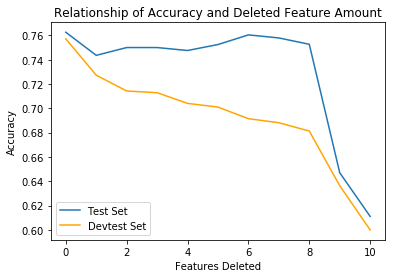

In [883]:
feature_num = list(range(0,11))
plt.plot(feature_num, accuracy_list_test, color='C0', label="Test Set")
plt.plot(feature_num, accuracy_list_devtest, color='orange', label="Devtest Set")
plt.xlabel('Features Deleted')
plt.ylabel('Accuracy')
plt.title('Relationship of Accuracy and Deleted Feature Amount')
plt.legend()
plt.show()

## PART 6: GET FINAL KNOWLEGE EXTRACTOR

In [932]:
def grammar_VBN(sent): 
    '''dataset: lists of word tokenized sentences'''
    
    # Second part: used as verb, past participle (VBN)
    # IBM <NP> is/are <VB> located <VBN> at <IN> Chicago <NE>
    # IBM <NP>, <,> located <VBN> at <IN> Chicago <NE>, is a good company.
    # IBM <NP>, <,> which <WDT> is/are located at Chicago
    
    # IBM, a Chicago based company, is good.
    # Chicago <NE> based <VBN> company <NN>, <,> IBM <NP> is good.
    # Located <VBN> in <IN> Chicago <NE>, <,> IBM <NP> is a good company.
    
    VBN_list = ['located','sited','placed','headquartered','positioned',
                'stationed','situated','replaced',
                'Located','Sited','Placed','Headquartered','Positioned',
                'Stationed','Situated','Replaced']
    VBN_list_tag = [(word,"VBN") for word in VBN_list]
    verb_list_tag = [('is','VBZ'),('are','VBP')]
    
    VBN_grammar = r"""
    NE: {<NNP|NNPS>+(<,><NNP|NNPS>)*(<IN><NNP|NNPS>)*}
    NEP: {<DT>?(<JJ>*<NN>*<IN>)?<NE>}
    NP1: {<JJ>*<CD>?<NN.*>+<POS>?<NN.*>*<CD>?}
    NP2: {<''><''><NN.*><POS><''>}
    VB: {<VBZ|VBP>}
    CLAUSE: {<DT>?<NP1|NP2><,>?<WDT>?<VB>?<VBN><IN><NEP>}
    {((<NEP><VBN><NN.*>)|(<VBN><IN><NEP>))<,>?<DT>?<NP1|NP2>}
    """
    
    cp = nltk.RegexpParser(VBN_grammar)
    return_list = list()
    X_Y = list()
    leave2 = str()
    leave3 = str()
    if set(sent).intersection(set(VBN_list)):
        tags = pos_tag(sent)
        tree = cp.parse(tags)
        for subtree in tree.subtrees():
            if subtree.label() == 'CLAUSE': 
                leave = subtree.leaves()
                if set(leave).intersection(set(VBN_list_tag)) and set(leave).intersection(set(verb_list_tag)):
                    return_list.append(leave)
                    break
    return return_list


def grammar_special_VBPZ(sent): 
    '''dataset: lists of word tokenized sentences'''
    
    # Fourth part: other special verbs (lie, sit) used as verb(VB & VBP & VBZ)
    special_VBPZ_list = ['lie','sit','lies','sits']
    special_VBPZ_list_tag = [('lie','VBP'),('sit','VBP'),
                             ('lies','VBZ'),('sits','VBZ')]
    special_VBPZ_grammar = r"""
    NE: {<NNP|NNPS>+(<,><NNP|NNPS>)*(<IN><NNP|NNPS>)*}
    NEP: {<DT>?(<JJ>*<NN>*<IN>)?<NE>}
    NP1: {<JJ>*<CD>?<NN.*>+<POS>?<NN.*>*<CD>?}
    NP2: {<''><''><NN.*><POS><''>}
    VB: {<VBZ|VBP>}
    CLAUSE: {<DT>?<NP1|NP2>(<,>?<WDT>?)<VB><IN><NEP>}
    """
    cp = nltk.RegexpParser(special_VBPZ_grammar)
    return_list = list()
    
    if set(sent).intersection(set(special_VBPZ_list)):
        tags = pos_tag(sent)
        tree = cp.parse(tags)
        for subtree in tree.subtrees():
            if subtree.label() == 'CLAUSE': 
                leave = subtree.leaves()
                if set(leave).intersection(set(special_VBPZ_list_tag)):
                    return_list.append(leave)
                    break
    return return_list
    

def grammar_special_VBG(sent): 
    '''dataset: lists of word tokenized sentences'''
    
    # Fifth part: other special verbs (lie, sit) used as verb, gerund(VBG)
    special_VBG_list = ['lying','sitting','Lying','Sitting']
    special_VBG_list_tag = [(word,'VBG') for word in special_VBG_list]
    special_VBG_grammar = r"""
    NE: {<NNP|NNPS>+(<,><NNP|NNPS>)*(<IN><NNP|NNPS>)*}
    NEP: {<DT>?(<JJ>*<NN>*<IN>)?<NE>}
    NP1: {<JJ>*<CD>?<NN.*>+<POS>?<NN.*>*<CD>?}
    NP2: {<''><''><NN.*><POS><''>}
    VB: {<VBZ|VBP>}
    CLAUSE: {<DT>?<NP1|NP2><,>?(<WDT><VB>)?<VBG><IN><NEP>}
    {<VBG><IN><NEP><,><DT>?<NP1|NP2>}
    """

    cp = nltk.RegexpParser(special_VBG_grammar)
    return_list = list()
    if set(sent).intersection(set(special_VBG_list)):
        tags = pos_tag(sent)
        tree = cp.parse(tags)
        for subtree in tree.subtrees():
            if subtree.label() == 'CLAUSE': 
                leave = subtree.leaves()
                if set(leave).intersection(set(special_VBG_list_tag)):
                    return_list.append(leave)
                    break
    return return_list


def location_extract(dataset):
    return_list = list()
    
    for sent in dataset:
        list1 = grammar_VBN(sent)
        list2 = grammar_special_VBPZ(sent)
        list3 = grammar_special_VBG(sent)
        list_totle = [list1, list2, list3]
        for sublist in list_totle:
            if sublist:
                return_list += sublist
    return return_list
    

In [918]:
%%time
function_testset = readin_text_nohtml_notree(path, limit_n = 5000)

/Users/Queena/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:62: DeprecationWarning: 'U' mode is deprecated


CPU times: user 1min 39s, sys: 5.65 s, total: 1min 45s
Wall time: 1min 58s


In [922]:
len(function_testset)

253113

In [923]:
%%time
location_extract_function = location_extract(function_testset)

CPU times: user 3min 15s, sys: 758 ms, total: 3min 16s
Wall time: 3min 17s


In [924]:
len(location_extract_function)

54

In [925]:
location_extract_function[0]

[('This', 'DT'),
 ('tunnel', 'NN'),
 ('is', 'VBZ'),
 ('located', 'VBN'),
 ('at', 'IN'),
 ('the', 'DT'),
 ('Great', 'NNP'),
 ('Dividing', 'NNP'),
 ('Range', 'NNP')]

In [942]:
df = pd.DataFrame({'Sentence':location_extract_function})
 
writer = ExcelWriter('Part5_Sample.xlsx')
df.to_excel(writer,'Sheet1',index=False)
writer.save()